In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from arc.Binary_Architecture import Model
import os
from data.Data_Interface import DataInterface
from model.Model_Interface import ModelInterface
from cf.DiPACE_Plus import DiPACE_Plus
from cf.DiPACE_FA import DiPACE_FA
from cf.DiPACE import DiPACE
from eval.Evaluation import Evaluate
pd.set_option('display.max_columns', None)

/Users/jacobsanderson/Documents/DiPACE/.venv/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
df = pd.read_csv('datasets/heart.csv')

In [3]:
X = df.drop(columns=['target'])
y = df['target']

In [4]:
X = pd.get_dummies(X, columns=['sex', 'cp', 'fbs', 'restecg', 'exang', 'ca', 'slope', 'thal'])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_scaled = scaler.transform(X)

In [7]:
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [8]:
input_size = X_train.shape[1]
model = Model(input_size)

In [9]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
epochs = 200
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')

Epoch [10/200], Loss: 0.6578998565673828
Epoch [20/200], Loss: 0.5858023762702942
Epoch [30/200], Loss: 0.4954138398170471
Epoch [40/200], Loss: 0.40643417835235596
Epoch [50/200], Loss: 0.34126585721969604
Epoch [60/200], Loss: 0.2999255061149597
Epoch [70/200], Loss: 0.27059099078178406
Epoch [80/200], Loss: 0.24471719563007355
Epoch [90/200], Loss: 0.22025376558303833
Epoch [100/200], Loss: 0.19650386273860931
Epoch [110/200], Loss: 0.17401321232318878
Epoch [120/200], Loss: 0.15257203578948975
Epoch [130/200], Loss: 0.1322541981935501
Epoch [140/200], Loss: 0.11408829689025879
Epoch [150/200], Loss: 0.09845177084207535
Epoch [160/200], Loss: 0.08505811542272568
Epoch [170/200], Loss: 0.07370249927043915
Epoch [180/200], Loss: 0.06419749557971954
Epoch [190/200], Loss: 0.056127287447452545
Epoch [200/200], Loss: 0.04897858202457428


In [11]:
with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    predicted = (outputs >= 0.5).float()
    accuracy = (predicted == y_test_tensor).sum().item() / y_test.shape[0]
    print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.8360655737704918


In [12]:
model_path = 'pytorch_model.pth'
torch.save(model.state_dict(), model_path)

In [13]:
d = DataInterface(dataframe=df, target='target', continuous_features=['age', 'trestbps', 'chol', 'thalach', 'oldpeak'])
m = ModelInterface(model_path='../DiPACE/pytorch_model.pth', input_size = input_size)

In [14]:
df = df[df['target']==1]
query_index = np.random.choice(len(df))
query_instance = df.iloc[8].drop('target').to_list()

Desired class: tensor([0.], grad_fn=<RsubBackward1>)
Original class tensor([1.], grad_fn=<RoundBackward0>)
All CFs are classified as the desired class.
Final Loss: tensor(1.9784, grad_fn=<SubBackward0>)
Final Pred Loss: tensor(0., grad_fn=<MeanBackward0>)
Final Proximity Loss: tensor(0.6927, grad_fn=<AddBackward0>)
Final Diversity Loss: tensor(0.9130, grad_fn=<LinalgDetBackward0>)
Final Sparsity Loss: tensor(0.5647)
Final Plausibility Loss: tensor(3.6089, grad_fn=<AddBackward0>)
Unacceptably high loss. Perturbing relevant features.
All CFs are classified as the desired class.
Final Loss: tensor(1.8428, grad_fn=<SubBackward0>)
Final Pred Loss: tensor(0.0005, grad_fn=<MeanBackward0>)
Final Proximity Loss: tensor(0.6918, grad_fn=<AddBackward0>)
Final Diversity Loss: tensor(0.9281, grad_fn=<LinalgDetBackward0>)
Final Sparsity Loss: tensor(0.5207)
Final Plausibility Loss: tensor(3.3992, grad_fn=<AddBackward0>)
Unacceptably high loss. Perturbing relevant features.
All CFs are classified as t

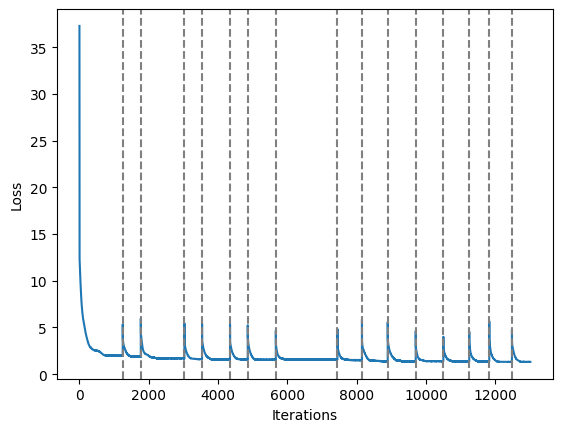

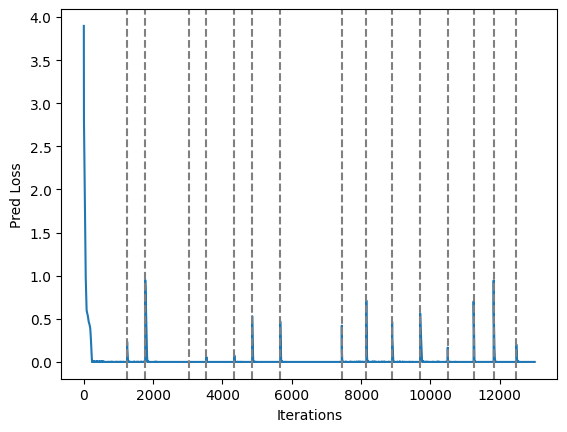

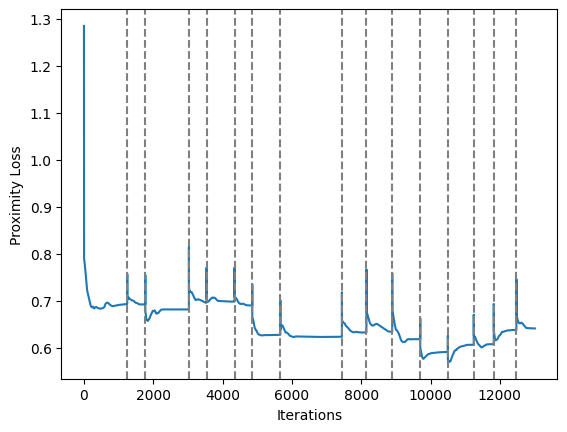

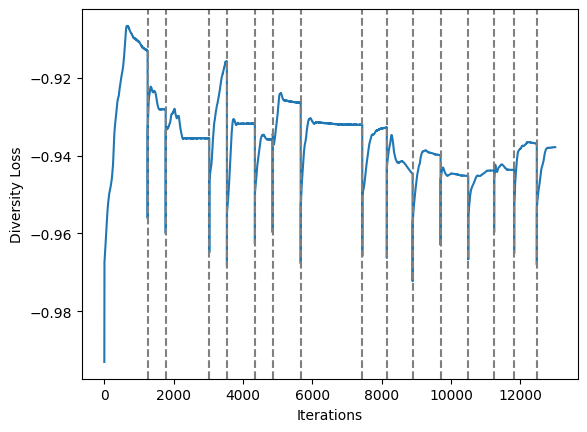

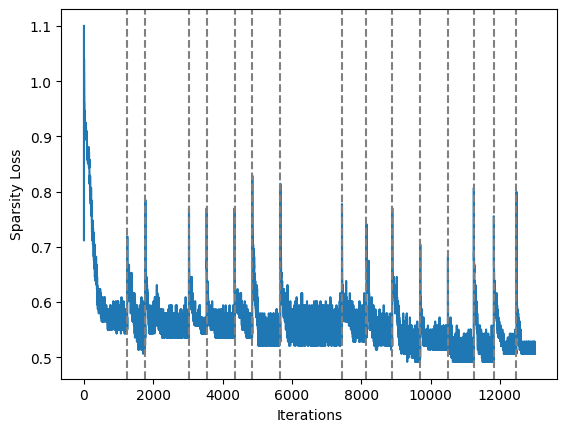

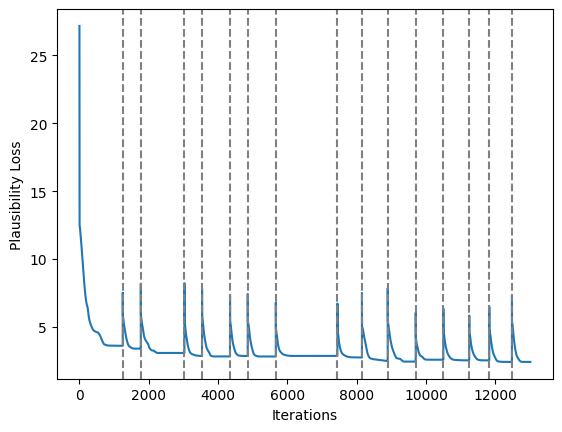

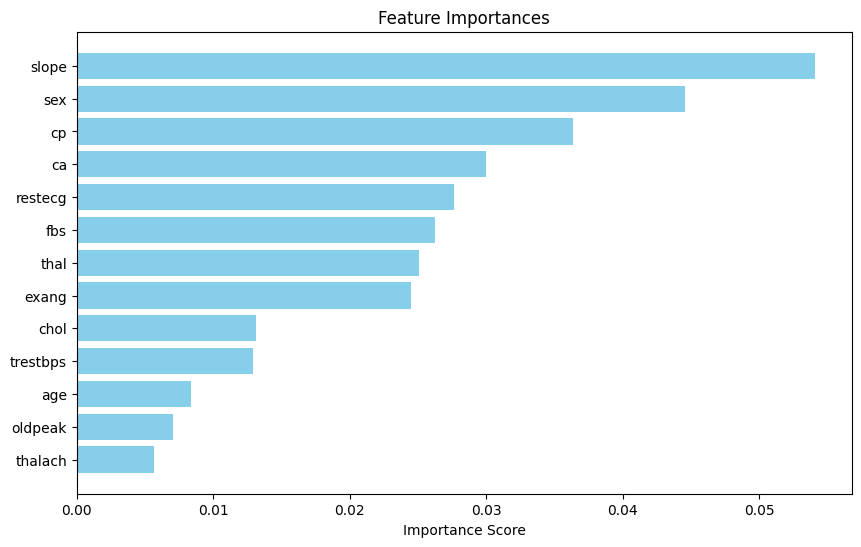

In [15]:
exp = DiPACE_FA(d, m)
cf = exp.generate_counterfactuals(query_instance, total_CFs=5, high_loss_threshold=1.0)

In [16]:
query_instance, cf_instances = cf
query_instance =  torch.Tensor(query_instance).float()
cf_instances = torch.Tensor(cf_instances).float()

In [ ]:
query_instance, cf_instances = cf
query_instance2 = pd.DataFrame(query_instance, columns=X.columns)
cf_instances2 = pd.DataFrame(cf_instances, columns=X.columns)
query_instance2 = query_instance.drop(columns=['slope_0', 'slope_1', 'slope_2'])
cf_instances2 = cf_instances.drop(columns=['slope_0', 'slope_1', 'slope_2'])
observed_instances = d.norm_encoded_features.drop(columns=['slope_0', 'slope_1', 'slope_2'])
query_instance2 = torch.Tensor(np.array(query_instance2)).float()
cf_instances2 = torch.Tensor(np.array(cf_instances2)).float()
query_instance =  torch.Tensor(query_instance).float()
cf_instances = torch.Tensor(cf_instances).float()

ValueError: Shape of passed values is (1, 30), indices imply (1, 27)

In [24]:
eval = Evaluate(d, m)
print(eval.evaluate_proximity(query_instance, cf_instances))
print(eval.evaluate_sparsity(query_instance, cf_instances))
print(eval.evaluate_diversity(cf_instances))
print(eval.evaluate_plausibility(cf_instances, d.norm_encoded_features, k=1))
print(eval.evaluate_confidence(cf_instances, desired_class=0))

tensor(0.4723)
tensor(0.4600)
tensor(0.9378)


TypeError: 'int' object is not callable